In [1]:
%matplotlib inline

In [2]:
from dualtree import dualtree, idualtree
import matplotlib.pyplot as plt
import numpy as n
from pywt import dwt, idwt

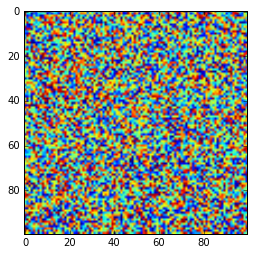

In [3]:
signal = n.random.random(size = (100,100))
plt.imshow(signal)

## Problem : perfect reconstruction lost when going over axis 1, but not axis 0

In [4]:
coeffs = dualtree(signal, level = 4, axis = 0)
reconstructed = idualtree(coeffs, axis = 0)
print('Over axis 0: perfect reconstruction is {}.'.format(n.allclose(signal, reconstructed)))

coeffs = dualtree(signal, level = 4, axis = 1)
reconstructed = idualtree(coeffs, axis = 1)
print('Over axis 1: prefect reconstruction is {}.'.format(n.allclose(signal, reconstructed)))

Over axis 0: perfect reconstruction is True.
Over axis 1: prefect reconstruction is True.


C:\Users\Laurent\OneDrive\McGill\Code\dualtree\dualtree\_dtcwt.py:254: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 36 but corresponding boolean dimension is 35
  return approx[mask].reshape(mask.shape)
C:\Users\Laurent\OneDrive\McGill\Code\dualtree\dualtree\_dtcwt.py:254: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 54 but corresponding boolean dimension is 53
  return approx[mask].reshape(mask.shape)
C:\Users\Laurent\OneDrive\McGill\Code\dualtree\dualtree\_dtcwt.py:254: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 36 but corresponding boolean dimension is 35
  return approx[mask].reshape(mask.shape)
C:\Users\Laurent\OneDrive\McGill\Code\dualtree\dualtree\_dtcwt.py:254: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 54 but corresponding boolean dimension is 53
  retu

## Investingating using pywt.dwt and pywt.idwt

### Two level, with a different wavelet at each level

In [5]:
cA1, cD1 = dwt(signal, wavelet = 'sym4', mode = 'constant', axis = 1)
cA2, cD2 = dwt(cA1, wavelet = 'db5', mode = 'constant', axis = 1)

cA1_rec = idwt(cA = cA2, cD = cD2, wavelet = 'db5', mode = 'constant', axis = 1)
reconstructed = idwt(cA = cA1_rec, cD = cD1, wavelet = 'sym4', mode = 'constant', axis = 1)

n.allclose(signal, reconstructed)

RuntimeError: C inverse wavelet transform failed

Naively performing two levels, with differing wavelets, yields an transform fail. In my experience, this means that the size of coefficients are problematic.

In [6]:
print(cA1.shape)
print(cA1_rec.shape)

(100, 53)
(100, 54)


This is to be expected, the approximation coefficiens can be a little longer than the detail ones. Let's resize

In [7]:
cA1, cD1 = dwt(signal, wavelet = 'sym4', mode = 'constant', axis = 1)
cA2, cD2 = dwt(cA1, wavelet = 'db5', mode = 'constant', axis = 1)

cA1_rec = idwt(cA = cA2, cD = cD2, wavelet = 'db5', mode = 'constant', axis = 1)
cA1_rec = n.resize(cA1_rec, cD1.shape)
reconstructed = idwt(cA = cA1_rec, cD = cD1, wavelet = 'sym4', mode = 'constant', axis = 1)

n.allclose(signal, reconstructed)

False

Now one column of cA1_rec has been deleted, but the reconstruction is not perfect anymore. Maybe the wrong column was deleted? Let's check.

In [8]:
cA1, cD1 = dwt(signal, wavelet = 'sym4', mode = 'constant', axis = 1)
cA2, cD2 = dwt(cA1, wavelet = 'db5', mode = 'constant', axis = 1)

cA1_rec = idwt(cA = cA2, cD = cD2, wavelet = 'db5', mode = 'constant', axis = 1)
cA1_rec = cA1_rec[:,1:]
reconstructed = idwt(cA = cA1_rec, cD = cD1, wavelet = 'sym4', mode = 'constant', axis = 1)

n.allclose(signal, reconstructed)

False

In [9]:
cA1, cD1 = dwt(signal, wavelet = 'sym4', mode = 'constant', axis = 1)
cA2, cD2 = dwt(cA1, wavelet = 'db5', mode = 'constant', axis = 1)

cA1_rec = idwt(cA = cA2, cD = cD2, wavelet = 'db5', mode = 'constant', axis = 1)
cA1_rec = cA1_rec[:,:-1]
reconstructed = idwt(cA = cA1_rec, cD = cD1, wavelet = 'sym4', mode = 'constant', axis = 1)

n.allclose(signal, reconstructed)

True

So the numpy.resize method does not discard the right column. How can we choose? Maybe always delete the last axis?

After testing, this is the case: the last 'column' of the axis should be discarded. Something like this:

In [10]:
def _normalize_shape(approx, detail):
    """ Returns approx coefficients the same size as detail, discarding the right parts. """
    mask = n.ones_like(detail, dtype = n.bool)
    return approx[mask].reshape(mask.shape) # Returns VisibleDeprecationWarning for some reason.

In [12]:
for axis in (0,1):
    cA1, cD1 = dwt(signal, wavelet = 'sym4', mode = 'constant', axis = axis)
    cA2, cD2 = dwt(cA1, wavelet = 'db5', mode = 'constant', axis = axis)

    cA1_rec = idwt(cA = cA2, cD = cD2, wavelet = 'db5', mode = 'constant', axis = axis)
    cA1_rec = _normalize_shape(cA1_rec, cD1)
    reconstructed = idwt(cA = cA1_rec, cD = cD1, wavelet = 'sym4', mode = 'constant', axis = axis)

    print(n.allclose(signal, reconstructed))

True
True


C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 54 but corresponding boolean dimension is 53
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 54 but corresponding boolean dimension is 53


### Testing in n-dimensions

In [14]:
signal = n.random.random(size = (10, 10, 10, 10))
for axis in range(signal.ndim): # test over all axes individually
    cA1, cD1 = dwt(signal, wavelet = 'sym4', mode = 'constant', axis = axis)
    cA2, cD2 = dwt(cA1, wavelet = 'db5', mode = 'constant', axis = axis)

    cA1_rec = idwt(cA = cA2, cD = cD2, wavelet = 'db5', mode = 'constant', axis = axis)
    cA1_rec = _normalize_shape(cA1_rec, cD1)
    reconstructed = idwt(cA = cA1_rec, cD = cD1, wavelet = 'sym4', mode = 'constant', axis = axis)

    print(n.allclose(signal, reconstructed))

True
True
True
True


Let's try to rewrite _normalize_shape to avoid warnings

In [18]:
def _normalize_shape(approx, detail, axis):
    """ Returns approx coefficients the same size as detail, discarding the right parts. """
    if approx.shape == detail.shape:
        return approx
    
    swapped = n.swapaxes(approx, axis, 0)
    approx = swapped[:-1]
    approx = n.swapaxes(approx, 0, axis)
    assert approx.shape[axis] == detail.shape[axis]
    return approx

In [19]:
signal = n.random.random(size = (10, 10, 10, 10))
for axis in range(signal.ndim): # test over all axes individually
    cA1, cD1 = dwt(signal, wavelet = 'sym4', mode = 'constant', axis = axis)
    cA2, cD2 = dwt(cA1, wavelet = 'db5', mode = 'constant', axis = axis)

    cA1_rec = idwt(cA = cA2, cD = cD2, wavelet = 'db5', mode = 'constant', axis = axis)
    cA1_rec = _normalize_shape(cA1_rec, cD1, axis)
    reconstructed = idwt(cA = cA1_rec, cD = cD1, wavelet = 'sym4', mode = 'constant', axis = axis)

    print(n.allclose(signal, reconstructed))

True
True
True
True


Great! That concludes axial dualtree implementation.